<a href="https://colab.research.google.com/github/thereaper01/Recommendation_System/blob/main/Recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import save_npz
from scipy.sparse import csr_matrix


##Using small part of movie lens data


In [ ]:
ratings = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movies = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


##EDA


In [ ]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


In [ ]:
user_freq = ratings[['userId', 'movieId']].groupby('userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
user_freq.head()

,userId,n_ratings
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


In [ ]:
print(f"Mean number of ratings for a given user: {user_freq['n_ratings'].mean():.2f}.")


Mean number of ratings for a given user: 165.30.


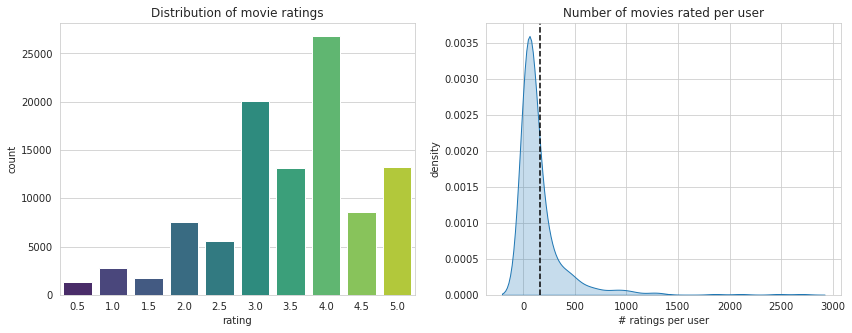

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings")

plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], shade=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per user")
plt.ylabel("density")
plt.title("Number of movies rated per user")
plt.show()

##Lowest and Highest rated movies


In [ ]:
mean_rating = ratings.groupby('movieId')[['rating']].mean()

lowest_rated = mean_rating['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]


,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [ ]:
highest_rated = mean_rating['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [ ]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


##AS Lamerica has only 2 ratings, we use Bayesian Average for popularity estimation
## Bayesian Average is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for movie $i$. In this case, our prior will be the average rating across all movies. By defintion, C represents "the typical dataset size". Let's make $C$ be the average number of ratings for a given 

In [ ]:
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

In [ ]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [ ]:
##best rated
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392070,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236457,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227052,Fight Club (1999)
224,260,251,4.231076,4.192646,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.190567,"Usual Suspects, The (1995)"


In [ ]:
##worst rated
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190377,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224426,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267268,Godzilla (1998)
1144,1499,27,1.925926,2.296800,Anaconda (1997)
1988,2643,16,1.687500,2.306841,Superman IV: The Quest for Peace (1987)


##Collaborative Filtering


In [ ]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    N = df['userId'].nunique()
    M = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

##Sparsity check


In [ ]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [ ]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Matrix sparsity: {round(sparsity*100,2)}%")


Matrix sparsity: 1.7%


In [ ]:
from scipy.sparse import save_npz

save_npz('/content/drive/MyDrive/Colab Notebooks/user_item_matrix.npz', X)

KNN for similar movies

In [ ]:
def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False):
    neighbour_ids = []
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

##Predictions

In [ ]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_ids = find_similar_movies(movie_id, X, k=10,metric="manhattan")
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}")
for i in similar_ids:
    print(movie_titles[i],"|Similar id:",i)

Because you watched Toy Story (1995)
Toy Story 2 (1999) |Similar id: 3114
Bug's Life, A (1998) |Similar id: 2355
Nutty Professor, The (1996) |Similar id: 788
Groundhog Day (1993) |Similar id: 1265
Willy Wonka & the Chocolate Factory (1971) |Similar id: 1073
Mission: Impossible (1996) |Similar id: 648
Babe (1995) |Similar id: 34
Monsters, Inc. (2001) |Similar id: 4886
Toy Story 3 (2010) |Similar id: 78499
Honey, I Shrunk the Kids (1989) |Similar id: 2054


In [ ]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1
similar_ids = find_similar_movies(movie_id, X, k=10, metric="euclidean")

movie_title = movie_titles[movie_id]
print(f"Because you watched {movie_title}:")
for i in similar_ids:
    print(movie_titles[i],"|Similar id:",i)
    

Because you watched Toy Story (1995):
Toy Story 2 (1999) |Similar id: 3114
Mission: Impossible (1996) |Similar id: 648
Independence Day (a.k.a. ID4) (1996) |Similar id: 780
Bug's Life, A (1998) |Similar id: 2355
Nutty Professor, The (1996) |Similar id: 788
Willy Wonka & the Chocolate Factory (1971) |Similar id: 1073
Babe (1995) |Similar id: 34
Groundhog Day (1993) |Similar id: 1265
Mask, The (1994) |Similar id: 367
Honey, I Shrunk the Kids (1989) |Similar id: 2054


In [ ]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1
similar_ids = find_similar_movies(movie_id, X, k=10, metric="minkowski")

movie_title = movie_titles[movie_id]
print(f"Because you watched {movie_title}:")
for i in similar_ids:
    print(movie_titles[i],"|Similar id:",i)

Because you watched Toy Story (1995):
Toy Story 2 (1999) |Similar id: 3114
Mission: Impossible (1996) |Similar id: 648
Independence Day (a.k.a. ID4) (1996) |Similar id: 780
Bug's Life, A (1998) |Similar id: 2355
Nutty Professor, The (1996) |Similar id: 788
Willy Wonka & the Chocolate Factory (1971) |Similar id: 1073
Babe (1995) |Similar id: 34
Groundhog Day (1993) |Similar id: 1265
Mask, The (1994) |Similar id: 367
Honey, I Shrunk the Kids (1989) |Similar id: 2054
